### Reddit Webscraping

In [2]:
# import sys
# !{sys.executable} -m pip install nltk.sentiment.vader
# nltk.downloader.download('stopwords')

# Import all dependencies
import praw
from IPython import display
import math
from pprint import pprint
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

%run ./'Basic_Import.ipynb'
## Which import the following libraries and functions
# import pandas as pd, numpy as np, matplotlib.pyplot as plt
# from jupyterthemes import jtplot
# jtplot.style()
# from sklearn.model_selection import train_test_split as tts
# from sklearn.preprocessing import StandardScaler
# from sklearn.metrics import confusion_matrix
# pd.set_option('display.max_columns', None)
# %matplotlib inline

# Import credentials for API
%run ./'Reddit_Credentials.ipynb'

In [3]:
# Extract headlines from subreddit
headlines = set()
for submission in reddit.subreddit('WorldNews').hot(limit=1000):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

666


### Sentiment Analysis on Headlines Pulled from Subreddit

In [6]:
# Building a Sentiment Intensity Analyzer (SIA)
sia = SIA();
results = [];
for line in headlines:
    polarity = sia.polarity_scores(line);
    polarity['Headline'] = line
    results.append(polarity);
pprint(results[:3], width = 100);
df = pd.DataFrame.from_records(results);

[{'Headline': 'S. Korea reports 86 new virus cases, total tops 10,000',
  'compound': 0.1779,
  'neg': 0.187,
  'neu': 0.576,
  'pos': 0.237},
 {'Headline': "Pakistan's trade deficit diminished by 26.45% in last nine months",
  'compound': -0.4019,
  'neg': 0.231,
  'neu': 0.769,
  'pos': 0.0},
 {'Headline': "Keir Starmer elected leader of Britain's Labour Party amid coronavirus crisis",
  'compound': -0.34,
  'neg': 0.259,
  'neu': 0.57,
  'pos': 0.171}]


Positive Headlines:

['UK: A new Coronavirus Status Checker will help the NHS coordinate its response and build up additional data. NHS asks people to share their coronavirus symptoms to help others. Health and Social '
 'Care Secretary: "We are asking the whole nation to join this effort"',
 'Coronavirus: United Arab Emirates extends curfew indefinitely due to disinfection program',
 'Global crises demand global solutions: is it time to create a world Constitution? A group of philosophers and activists propose a norm that serves as a "compass of all governments for the good '
 'government of the world"',
 "Covid 19 coronavirus: Expert says it's better to wear a mask",
 'India reports highest spike in positive cases over last 24 hours']

Negative Headlines:

["Pakistan's trade deficit diminished by 26.45% in last nine months",
 'EU Commission apologises to Italy over coronavirus response. "widespread dismay in Italy over Europe\'s response to the pandemic, starting with an initial fail

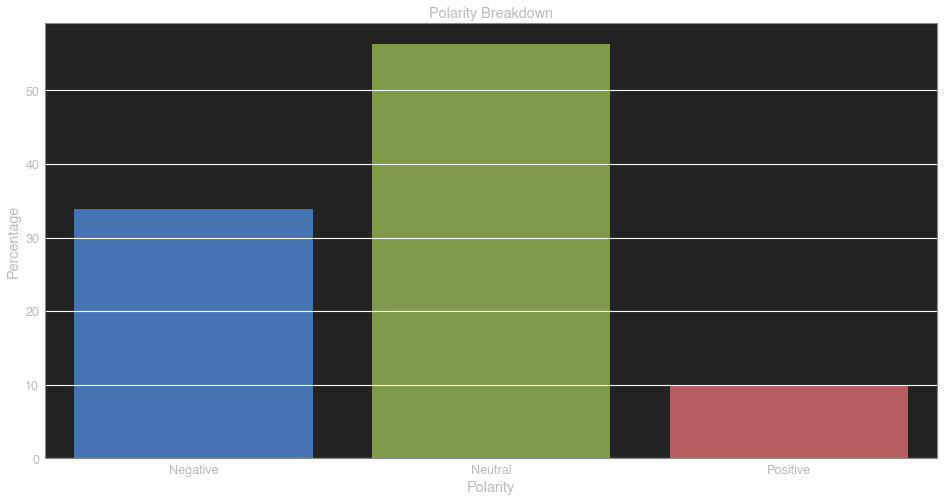

In [11]:
# Consider Pos-Neg Scale from 1 to -1; Compound >= 0.4 as Positive, <= 0.4 as Negative; Others will be Neutral
df['Label'] = 0
df.loc[df['compound'] >= 0.4, 'Label'] = 1
df.loc[df['compound'] <= -0.4, 'Label'] = -1
df.head(20)

# Print the Positive and Negative Headlines
print("Positive Headlines:\n")
pprint(list(df[df['Label'] == 1].Headline)[:5], width=200)

print("\nNegative Headlines:\n")
pprint(list(df[df['Label'] == -1].Headline)[:5], width=200)

# Count the number of each category
print(df.Label.value_counts())
print(df.Label.value_counts(normalize=True) * 100)

# Plot the bar graph of results using seaborn
fig, ax = plt.subplots(figsize=(16, 8))
counts = df.Label.value_counts(normalize=True) * 100
sns.barplot(x=counts.index, y=counts, ax=ax)
ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
ax.set_ylabel("Percentage")
ax.set_xlabel('Polarity')
ax.grid(axis='y', color = 'w')
plt.title('Polarity Breakdown')
plt.show()

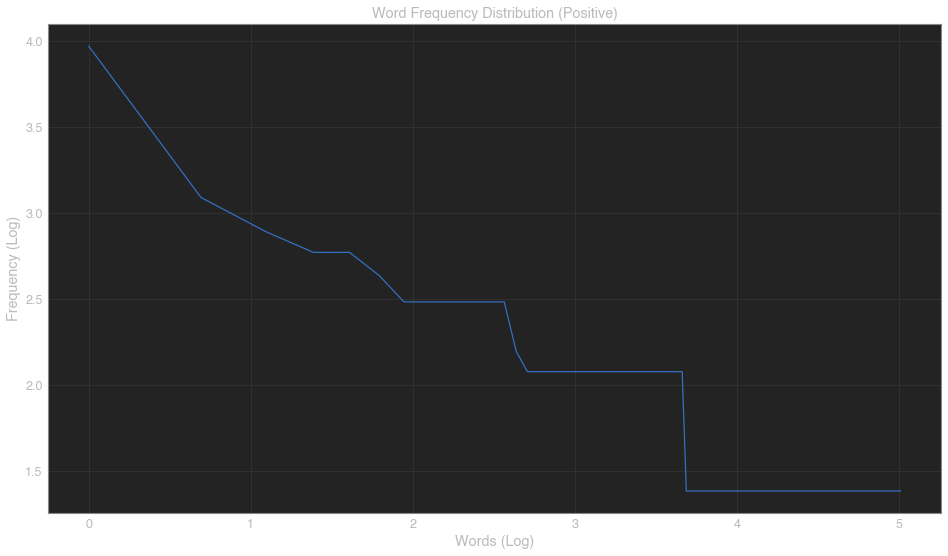

In [12]:
# Tokenize headlines and account for stop words
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words('english')

def process_text(headlines):
    tokens = []
    for line in headlines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks) 
    return tokens

pos_lines = list(df[df.Label == 1].Headline)
pos_tokens = process_text(pos_lines)
pos_freq = nltk.FreqDist(pos_tokens)
pos_freq.most_common(20)

y_val = [x[1] for x in pos_freq.most_common()]
y_final = []
for i, k, z, t in zip(y_val[0::4], y_val[1::4], y_val[2::4], y_val[3::4]):
    y_final.append(math.log(i + k + z + t))

x_val = [math.log(i + 1) for i in range(len(y_final))]
fig = plt.figure(figsize=(16,9))
plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Positive)")
plt.plot(x_val, y_final)
#plt.grid(axis='y', color='y')
plt.show()
# Power Law distribution == True; follows Zipf's Law

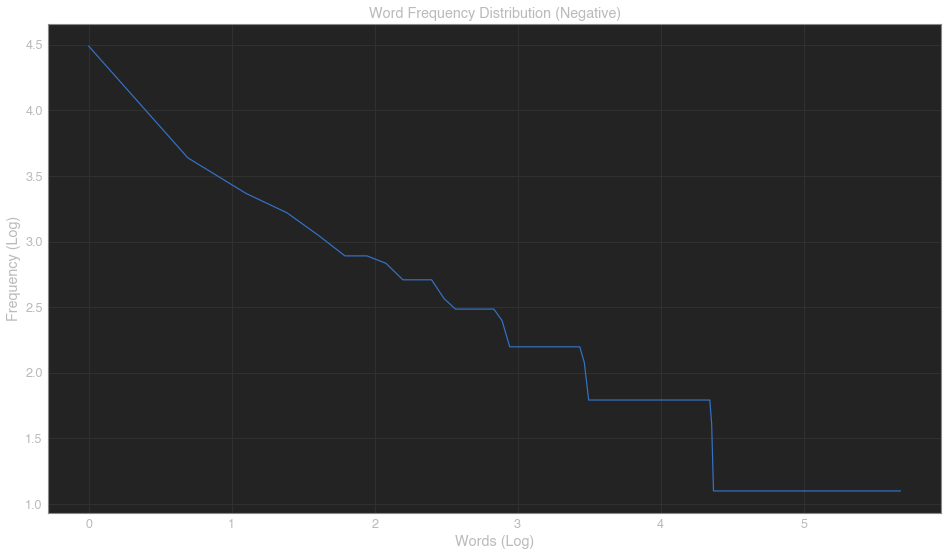

In [188]:
neg_lines = list(df[df.Label == -1].Headline)
neg_tokens = process_text(neg_lines)
neg_freq = nltk.FreqDist(neg_tokens)
neg_freq.most_common(20)

y_val = [x[1] for x in neg_freq.most_common()]
y_final = []
for i, k, z in zip(y_val[0::3], y_val[1::3], y_val[2::3]):
    if i + k + z == 0:
        break
    y_final.append(math.log(i + k + z))

x_val = [math.log(i+1) for i in range(len(y_final))]
fig = plt.figure(figsize=(16,9))
plt.xlabel("Words (Log)")
plt.ylabel("Frequency (Log)")
plt.title("Word Frequency Distribution (Negative)")
plt.plot(x_val, y_final)
plt.show()
# Power law distribution == True; follows Zipf's Law

### Applying SVM and Naive Bayes Classifiers

In [13]:
%run ./'Basic_Import.ipynb'
df.head()

,neg,neu,pos,compound,Headline,Label
0,0.187,0.576,0.237,0.1779,"S. Korea reports 86 new virus cases, total top...",0
1,0.231,0.769,0.000,-0.4019,Pakistan's trade deficit diminished by 26.45% ...,-1
2,0.259,0.570,0.171,-0.3400,Keir Starmer elected leader of Britain's Labou...,0
3,0.124,0.793,0.083,-0.4588,EU Commission apologises to Italy over coronav...,-1
4,0.444,0.556,0.000,-0.4588,"WHO warns, Young People experiencing severe di...",-1


/Users/morgan/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/morgan/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


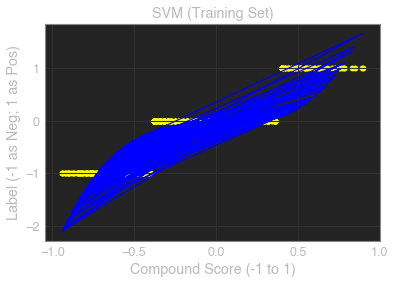

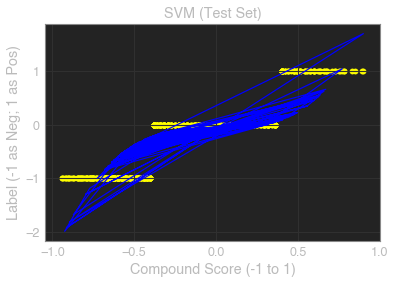

In [14]:
X = df.iloc[:, 3:4].values
y = df.iloc[:, 5:6].values
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25, random_state = 0)

# Using SVR and Gaussian Kernel to Create Prediction Model

from sklearn.svm import SVR

reg = SVR(kernel = 'poly')
reg.fit(X_train, y_train)
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
plt.scatter(X, y, color = 'yellow')
plt.plot(X_train, reg.predict(X_train), color = 'blue')
plt.title('SVM (Training Set)')
plt.xlabel('Compound Score (-1 to 1)')
plt.ylabel('Label (-1 as Neg; 1 as Pos)')
plt.show()

# X_test = sc.transform(X_test)
plt.scatter(X, y, color = 'yellow')
plt.plot(X_test, reg.predict(X_test), color = 'blue')
plt.title('SVM (Test Set)')
plt.xlabel('Compound Score (-1 to 1)')
plt.ylabel('Label (-1 as Neg; 1 as Pos)')
plt.show()

# y_pred = reg.predict(sc_X.transform(np.array([[6.5]])))
# y_pred

/Users/morgan/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


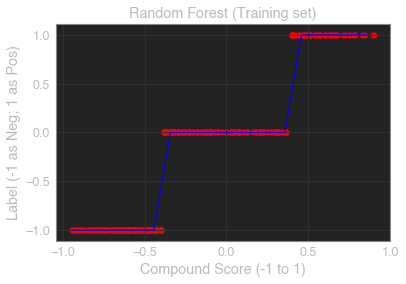

[0.]


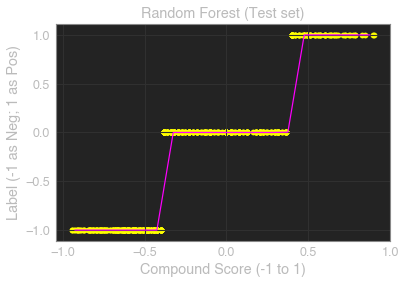

[0.]


In [21]:
from sklearn.ensemble import RandomForestRegressor
# Random Forest on Training Set
X = df.iloc[:, 3:4].values
y = df.iloc[:, 5:6].values
y = np.reshape(y, (-1,1))
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25, random_state = 0)
forest = RandomForestRegressor(n_estimators=1000,random_state=0)
forest.fit(X_train,y_train)
X_grid = np.arange(min(X_train), max(X_train), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'red')
plt.plot(X_grid, forest.predict(X_grid), color = 'blue')
plt.title('Random Forest (Training set)')
plt.xlabel('Compound Score (-1 to 1)')
plt.ylabel('Label (-1 as Neg; 1 as Pos)')
plt.show()

y_pred = forest.predict([[0.3]]).astype(float)
print(y_pred)

# Random Forest on Test Set
X_grid = np.arange(min(X_test), max(X_test), 0.1)
X_grid = X_grid.reshape((len(X_grid), 1))
plt.scatter(X, y, color = 'yellow')
plt.plot(X_grid, forest.predict(X_grid), color = 'magenta')
plt.title('Random Forest (Test set)')
plt.xlabel('Compound Score (-1 to 1)')
plt.ylabel('Label (-1 as Neg; 1 as Pos)')
plt.show()

y_pred2 = forest.predict([[0.3]]).astype(float)
print(y_pred2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


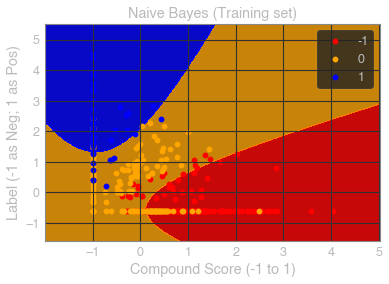

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


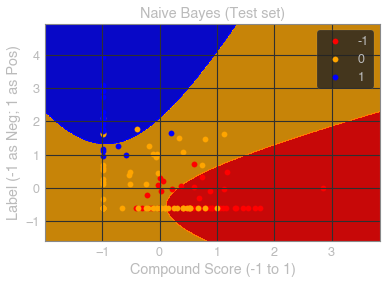

In [16]:
# Splitting the dataset into the Training set and Test set
X = df.iloc[:, [0,2]].values
y = df.iloc[:, 5].values
X_train, X_test, y_train, y_test = tts(X, y, test_size = 0.25, random_state = 0)

# Feature Scaling
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Naive Bayes to the Training set
from sklearn.naive_bayes import GaussianNB
classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

# Visualising the Training set results
from matplotlib.colors import ListedColormap
X_set, y_set = X_train, y_train
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'orange','blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red','orange','blue'))(i), label = j)
plt.title('Naive Bayes (Training set)')
plt.xlabel('Compound Score (-1 to 1)')
plt.ylabel('Label (-1 as Neg; 1 as Pos)')
#plt.xticks(range(-1, 1))
plt.legend()
plt.show()

# Visualising the Test set results
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red','orange','blue')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red','orange','blue'))(i), label = j)
plt.title('Naive Bayes (Test set)')
plt.xlabel('Compound Score (-1 to 1)')
plt.ylabel('Label (-1 as Neg; 1 as Pos)')
#plt.xticks(range(-1, 1))
plt.legend()
plt.show()